# SGD

SGDとは、確率的勾配降下法の略称であり、勾配方向へある一定の距離だけ進むという単純な方法ですが、今でも多くの研究で使われている。実装が簡単ではあるが、欠点もある。

In [1]:
class SGD :
    def __init__(self,lr=0.01):
        self.lr = lr
        
    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

ここで、初期化の際の引数であるlrは学習係数を表し、これはインスタンス係数として保持される。

# SDGの欠点

関数の形が等方的でない、伸びた形の関数だと非効率な経路で探索することになる。原因は、勾配の方向が本来の最小値ではない方向をさしていることに起因する。

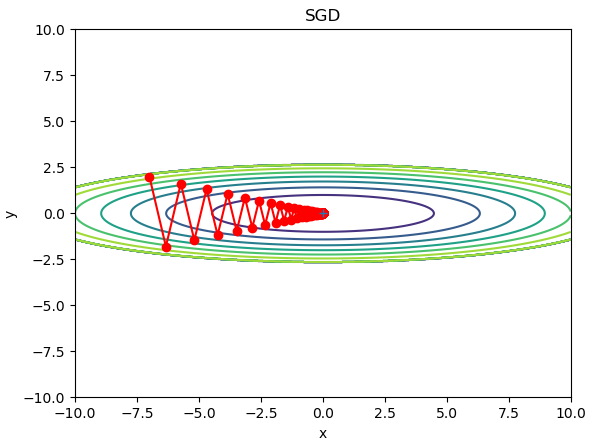

# Momentum

モーメンタムとは、運動量という意味で物理に関係がある。数式で表すと次のようになる。
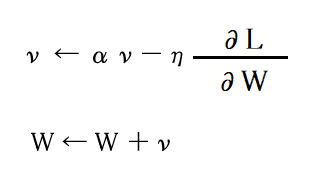

見慣れないvという変数がありますが、これは物理でいうところの速度に対応する

## Momentumの実装

In [3]:
class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

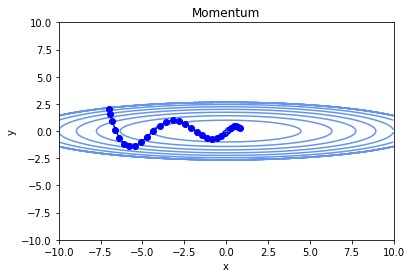

SDGと比べて、ジグザグしていないのが分かる。これはx軸方向に受ける力はとても小さいが、常に同じ方向に一定して加速されている。y軸方向には受ける力は大きいが、正と負の方向の力を交互に受けるため、それらが打ち消しあい、y軸方向の速度は安定しない。それによって、SDGより早くx軸方向へ早く近づき、ジグザグにならない。

# AdaGrad

ニューラルネットワーク学習において重要な学習係数に関するテクニックとして学習係数の減衰という方法がある。これは学習が進むにつれて学習係数を小さくするという方法である。これを発展させたのがAdaGradである。AdaGradは一つ一つのパラメータに対して適応的に学習係数を調整しながら学習を行う手法。
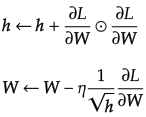

ここで新しく登場したhはこれまで経験した勾配の値を二乗和として保持している。そしてパラメータ更新の際に、$ \frac{1}{\sqrt{h}} $ を乗算することで、学習スケールを調整する。

In [4]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) #1e-7は0で除算してしまうことを防ぐため


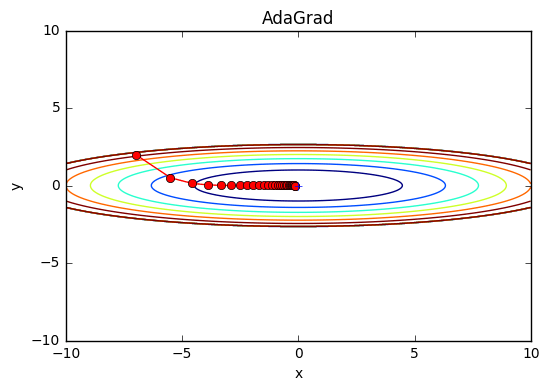

# Adam

AdamはMomentumとAdaGradを融合させたような手法。ハイパーパラメータのバイアス調整が行われている。

In [5]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

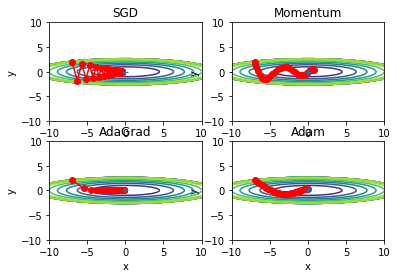

In [7]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict



def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# 重みの初期値

重みの初期値によってニューラルネットワークの学習の成否が分かれることがある。

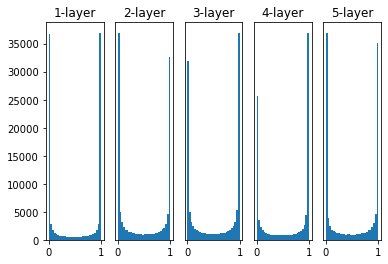

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1
    

    a = np.dot(x, w)


    z = sigmoid(a)
    

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

上記は重みの初期値として標準偏差1のガウス分布を用いたとき。
ここで使われているsigmoid関数の性質上、0と1に偏ったデータ分布では勾配の値がどんどん小さくなって消えてしまう。これを勾配消失という。

続いて、Xavier Glototらの論文で推奨される重みの初期値、通称Xavierの初期値をつかってみる。(前層ノードの個数を $ n $ とした場合、$ \frac{1}{\sqrt{n}} $　を標準偏差に持つ分布を使うというもの）

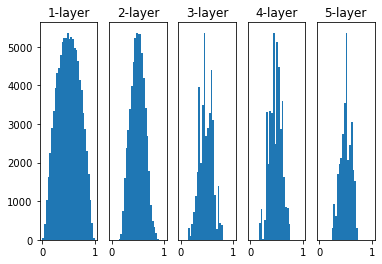

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    node_num = 100 # 前層のノードの数   
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    

    a = np.dot(x, w)


    z = sigmoid(a)
   

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavierの初期値を使った結果は、ややいびつな形だが、前よりも広がりのあるグラフになっている。

tanh

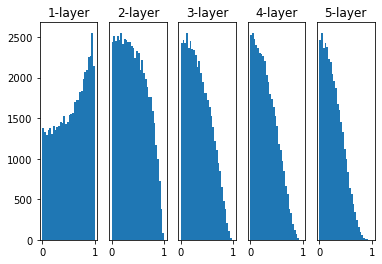

In [17]:
# import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    node_num = 100 # 前層のノードの数   
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    a = np.dot(x, w)

    
    z = tanh(a)
     

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

sigmoidの代わりにtanh関数を用いた。tanh関数はシグモイドと同じくS字の関数だが、活性化関数に望ましい原点対称のためきれいな形になるらしい。

ReLU関数では専用のHeの初期値というものを用いる。

# Batch Normalization

Batch Normalizationは各層でのアクティベーションの分布を適度な広がりを持つように調節できる。
Batch Normalizationには以下の利点がある

・学習を早く進行させることができる

・初期値にそれほど依存しない

・過学習を抑制する


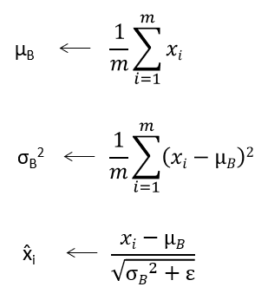

データの分布が平均が0、分散が1になるように正規化する。

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
============== 1/16 ==============
epoch:0 | 0.097 - 0.086
epoch:1 | 0.097 - 0.082
epoch:2 | 0.097 - 0.126


C:\Users\kouta\common\functions.py:32: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策


epoch:3 | 0.097 - 0.158
epoch:4 | 0.097 - 0.18
epoch:5 | 0.097 - 0.2
epoch:6 | 0.097 - 0.227
epoch:7 | 0.097 - 0.245
epoch:8 | 0.097 - 0.265
epoch:9 | 0.097 - 0.285
epoch:10 | 0.097 - 0.299
epoch:11 | 0.097 - 0.318
epoch:12 | 0.097 - 0.338
epoch:13 | 0.097 - 0.361
epoch:14 | 0.097 - 0.394
epoch:15 | 0.097 - 0.405
epoch:16 | 0.097 - 0.433
epoch:17 | 0.097 - 0.455


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.467
epoch:19 | 0.097 - 0.477
============== 2/16 ==============
epoch:0 | 0.094 - 0.103
epoch:1 | 0.097 - 0.104
epoch:2 | 0.097 - 0.14
epoch:3 | 0.097 - 0.138
epoch:4 | 0.097 - 0.158
epoch:5 | 0.097 - 0.182
epoch:6 | 0.097 - 0.209
epoch:7 | 0.097 - 0.229
epoch:8 | 0.097 - 0.252
epoch:9 | 0.097 - 0.277
epoch:10 | 0.097 - 0.301
epoch:11 | 0.097 - 0.309
epoch:12 | 0.097 - 0.333
epoch:13 | 0.097 - 0.361
epoch:14 | 0.097 - 0.374
epoch:15 | 0.097 - 0.398
epoch:16 | 0.097 - 0.422


No handles with labels found to put in legend.


epoch:17 | 0.097 - 0.444
epoch:18 | 0.097 - 0.454
epoch:19 | 0.097 - 0.466
============== 3/16 ==============
epoch:0 | 0.16 - 0.104
epoch:1 | 0.442 - 0.104
epoch:2 | 0.548 - 0.113
epoch:3 | 0.644 - 0.155
epoch:4 | 0.718 - 0.208
epoch:5 | 0.758 - 0.25
epoch:6 | 0.798 - 0.288
epoch:7 | 0.84 - 0.323
epoch:8 | 0.889 - 0.357
epoch:9 | 0.907 - 0.386
epoch:10 | 0.909 - 0.419
epoch:11 | 0.929 - 0.446
epoch:12 | 0.949 - 0.465
epoch:13 | 0.958 - 0.504
epoch:14 | 0.969 - 0.533
epoch:15 | 0.973 - 0.546
epoch:16 | 0.974 - 0.568
epoch:17 | 0.98 - 0.587


No handles with labels found to put in legend.


epoch:18 | 0.983 - 0.594
epoch:19 | 0.984 - 0.63
============== 4/16 ==============
epoch:0 | 0.116 - 0.096
epoch:1 | 0.254 - 0.142
epoch:2 | 0.381 - 0.187
epoch:3 | 0.478 - 0.246
epoch:4 | 0.536 - 0.312
epoch:5 | 0.601 - 0.384
epoch:6 | 0.65 - 0.443
epoch:7 | 0.671 - 0.503
epoch:8 | 0.696 - 0.554
epoch:9 | 0.71 - 0.596
epoch:10 | 0.738 - 0.622
epoch:11 | 0.766 - 0.635
epoch:12 | 0.76 - 0.665
epoch:13 | 0.764 - 0.69
epoch:14 | 0.795 - 0.703
epoch:15 | 0.805 - 0.711
epoch:16 | 0.813 - 0.72
epoch:17 | 0.819 - 0.736
epoch:18 | 0.838 - 0.758


No handles with labels found to put in legend.


epoch:19 | 0.846 - 0.769
============== 5/16 ==============
epoch:0 | 0.132 - 0.124
epoch:1 | 0.143 - 0.159
epoch:2 | 0.158 - 0.293
epoch:3 | 0.178 - 0.423
epoch:4 | 0.194 - 0.51
epoch:5 | 0.202 - 0.579
epoch:6 | 0.217 - 0.627
epoch:7 | 0.226 - 0.671
epoch:8 | 0.243 - 0.702
epoch:9 | 0.253 - 0.727
epoch:10 | 0.268 - 0.758
epoch:11 | 0.27 - 0.782
epoch:12 | 0.277 - 0.791
epoch:13 | 0.283 - 0.811
epoch:14 | 0.297 - 0.824
epoch:15 | 0.308 - 0.84
epoch:16 | 0.32 - 0.855


No handles with labels found to put in legend.


epoch:17 | 0.336 - 0.871
epoch:18 | 0.341 - 0.877
epoch:19 | 0.336 - 0.889
============== 6/16 ==============
epoch:0 | 0.139 - 0.118
epoch:1 | 0.112 - 0.224
epoch:2 | 0.129 - 0.487
epoch:3 | 0.118 - 0.595
epoch:4 | 0.117 - 0.666
epoch:5 | 0.119 - 0.706
epoch:6 | 0.12 - 0.749
epoch:7 | 0.119 - 0.785
epoch:8 | 0.116 - 0.805
epoch:9 | 0.116 - 0.832
epoch:10 | 0.116 - 0.855
epoch:11 | 0.116 - 0.867
epoch:12 | 0.116 - 0.878
epoch:13 | 0.116 - 0.896
epoch:14 | 0.116 - 0.907
epoch:15 | 0.116 - 0.918
epoch:16 | 0.116 - 0.93
epoch:17 | 0.116 - 0.937
epoch:18 | 0.116 - 0.945
epoch:19 | 0.116 - 0.952


No handles with labels found to put in legend.


============== 7/16 ==============
epoch:0 | 0.116 - 0.107
epoch:1 | 0.116 - 0.323
epoch:2 | 0.116 - 0.598
epoch:3 | 0.116 - 0.692
epoch:4 | 0.116 - 0.752
epoch:5 | 0.116 - 0.804
epoch:6 | 0.116 - 0.837
epoch:7 | 0.116 - 0.859
epoch:8 | 0.116 - 0.886
epoch:9 | 0.116 - 0.91
epoch:10 | 0.116 - 0.929
epoch:11 | 0.116 - 0.94
epoch:12 | 0.116 - 0.956
epoch:13 | 0.116 - 0.969
epoch:14 | 0.116 - 0.974
epoch:15 | 0.116 - 0.98
epoch:16 | 0.116 - 0.983


No handles with labels found to put in legend.


epoch:17 | 0.116 - 0.986
epoch:18 | 0.116 - 0.991
epoch:19 | 0.116 - 0.993
============== 8/16 ==============
epoch:0 | 0.126 - 0.093
epoch:1 | 0.117 - 0.477
epoch:2 | 0.117 - 0.695
epoch:3 | 0.117 - 0.778
epoch:4 | 0.117 - 0.816
epoch:5 | 0.117 - 0.869
epoch:6 | 0.117 - 0.918
epoch:7 | 0.117 - 0.949
epoch:8 | 0.117 - 0.965
epoch:9 | 0.117 - 0.975
epoch:10 | 0.117 - 0.982
epoch:11 | 0.117 - 0.991
epoch:12 | 0.117 - 0.991
epoch:13 | 0.117 - 0.993
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 9/16 ==============
epoch:0 | 0.1 - 0.186
epoch:1 | 0.117 - 0.492
epoch:2 | 0.117 - 0.699
epoch:3 | 0.117 - 0.814
epoch:4 | 0.117 - 0.884
epoch:5 | 0.117 - 0.913
epoch:6 | 0.117 - 0.954
epoch:7 | 0.117 - 0.958
epoch:8 | 0.117 - 0.977
epoch:9 | 0.117 - 0.983
epoch:10 | 0.117 - 0.987
epoch:11 | 0.117 - 0.99
epoch:12 | 0.117 - 0.989
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.996
epoch:18 | 0.117 - 0.996
epoch:19 | 0.117 - 0.998


No handles with labels found to put in legend.


============== 10/16 ==============
epoch:0 | 0.117 - 0.159
epoch:1 | 0.117 - 0.558
epoch:2 | 0.117 - 0.707
epoch:3 | 0.117 - 0.807
epoch:4 | 0.117 - 0.93
epoch:5 | 0.117 - 0.962
epoch:6 | 0.117 - 0.931
epoch:7 | 0.117 - 0.978
epoch:8 | 0.117 - 0.975
epoch:9 | 0.117 - 0.988
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.988
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.947
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.985
epoch:19 | 0.117 - 0.995
============== 11/16 ==============
epoch:0 | 0.1 - 0.137
epoch:1 | 0.105 - 0.539
epoch:2 | 0.117 - 0.632
epoch:3 | 0.117 - 0.752
epoch:4 | 0.117 - 0.748
epoch:5 | 0.117 - 0.689
epoch:6 | 0.117 - 0.784
epoch:7 | 0.117 - 0.765
epoch:8 | 0.117 - 0.396
epoch:9 | 0.117 - 0.93
epoch:10 | 0.117 - 0.923
epoch:11 | 0.117 - 0.961
epoch:12 | 0.117 - 0.974
epoch:13 | 0.117 - 0.985
epoch:14 | 0.117 - 0.981
epoch:15 | 0.117 - 0.991
epoch:16 | 0.117 - 0.99
epoch:17 | 0.117 - 0.994
epoch:18 | 0.117 - 0.994


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.994
============== 12/16 ==============
epoch:0 | 0.117 - 0.136
epoch:1 | 0.117 - 0.506
epoch:2 | 0.116 - 0.734
epoch:3 | 0.117 - 0.749
epoch:4 | 0.116 - 0.82
epoch:5 | 0.117 - 0.839
epoch:6 | 0.117 - 0.782
epoch:7 | 0.117 - 0.858
epoch:8 | 0.117 - 0.883
epoch:9 | 0.117 - 0.889
epoch:10 | 0.117 - 0.892
epoch:11 | 0.117 - 0.879
epoch:12 | 0.117 - 0.893
epoch:13 | 0.117 - 0.899
epoch:14 | 0.117 - 0.902
epoch:15 | 0.117 - 0.903
epoch:16 | 0.117 - 0.903
epoch:17 | 0.117 - 0.901


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.905
epoch:19 | 0.117 - 0.904
============== 13/16 ==============
epoch:0 | 0.1 - 0.225
epoch:1 | 0.105 - 0.491
epoch:2 | 0.105 - 0.562
epoch:3 | 0.105 - 0.678
epoch:4 | 0.116 - 0.554
epoch:5 | 0.117 - 0.724
epoch:6 | 0.117 - 0.756
epoch:7 | 0.117 - 0.762
epoch:8 | 0.117 - 0.728
epoch:9 | 0.117 - 0.72
epoch:10 | 0.117 - 0.784
epoch:11 | 0.117 - 0.771
epoch:12 | 0.117 - 0.793
epoch:13 | 0.116 - 0.773
epoch:14 | 0.116 - 0.742
epoch:15 | 0.116 - 0.795
epoch:16 | 0.116 - 0.802
epoch:17 | 0.116 - 0.808
epoch:18 | 0.116 - 0.805


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.806
============== 14/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.117 - 0.401
epoch:2 | 0.117 - 0.465
epoch:3 | 0.117 - 0.449
epoch:4 | 0.117 - 0.513
epoch:5 | 0.117 - 0.514
epoch:6 | 0.117 - 0.376
epoch:7 | 0.116 - 0.506
epoch:8 | 0.117 - 0.559
epoch:9 | 0.117 - 0.59
epoch:10 | 0.117 - 0.576
epoch:11 | 0.117 - 0.583
epoch:12 | 0.117 - 0.606
epoch:13 | 0.117 - 0.599
epoch:14 | 0.116 - 0.615
epoch:15 | 0.116 - 0.614
epoch:16 | 0.116 - 0.617


No handles with labels found to put in legend.


epoch:17 | 0.116 - 0.622
epoch:18 | 0.116 - 0.598
epoch:19 | 0.116 - 0.611
============== 15/16 ==============
epoch:0 | 0.116 - 0.111
epoch:1 | 0.117 - 0.26
epoch:2 | 0.117 - 0.37
epoch:3 | 0.117 - 0.37
epoch:4 | 0.117 - 0.391
epoch:5 | 0.117 - 0.392
epoch:6 | 0.117 - 0.399
epoch:7 | 0.117 - 0.402
epoch:8 | 0.117 - 0.4
epoch:9 | 0.117 - 0.404
epoch:10 | 0.117 - 0.414
epoch:11 | 0.117 - 0.4
epoch:12 | 0.117 - 0.401
epoch:13 | 0.117 - 0.403
epoch:14 | 0.117 - 0.405
epoch:15 | 0.117 - 0.403
epoch:16 | 0.117 - 0.401
epoch:17 | 0.117 - 0.401
epoch:18 | 0.117 - 0.402


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.401
============== 16/16 ==============
epoch:0 | 0.105 - 0.117
epoch:1 | 0.117 - 0.259
epoch:2 | 0.116 - 0.218
epoch:3 | 0.116 - 0.323
epoch:4 | 0.116 - 0.398
epoch:5 | 0.116 - 0.383
epoch:6 | 0.116 - 0.398
epoch:7 | 0.116 - 0.421
epoch:8 | 0.116 - 0.422
epoch:9 | 0.116 - 0.425
epoch:10 | 0.116 - 0.427
epoch:11 | 0.116 - 0.424
epoch:12 | 0.117 - 0.436
epoch:13 | 0.116 - 0.422
epoch:14 | 0.117 - 0.441
epoch:15 | 0.117 - 0.43
epoch:16 | 0.117 - 0.43
epoch:17 | 0.117 - 0.43
epoch:18 | 0.117 - 0.428
epoch:19 | 0.117 - 0.43


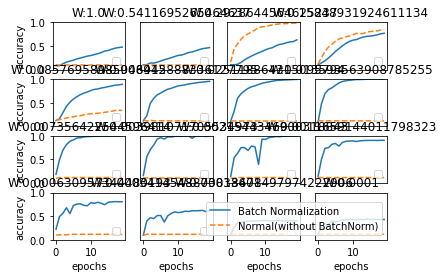

In [24]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

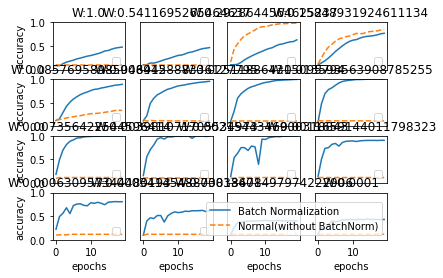

# 過学習

過学習が起こる原因として主に以下二つがあげられる。

・パラメータを大量に持ち、表現力の高いモデルであること。

・訓練データが少ないこと。

以下、この要因を2つとも満たして過学習を発生させる。

epoch:0, train acc:0.03333333333333333, test acc:0.0799
epoch:1, train acc:0.043333333333333335, test acc:0.0799
epoch:2, train acc:0.08666666666666667, test acc:0.0867
epoch:3, train acc:0.11666666666666667, test acc:0.0967
epoch:4, train acc:0.13333333333333333, test acc:0.1146
epoch:5, train acc:0.16, test acc:0.1356
epoch:6, train acc:0.21, test acc:0.1686
epoch:7, train acc:0.24, test acc:0.1929
epoch:8, train acc:0.25, test acc:0.2041
epoch:9, train acc:0.27, test acc:0.2238
epoch:10, train acc:0.2866666666666667, test acc:0.2403
epoch:11, train acc:0.33666666666666667, test acc:0.2612
epoch:12, train acc:0.35, test acc:0.2706
epoch:13, train acc:0.37666666666666665, test acc:0.277
epoch:14, train acc:0.41, test acc:0.3039
epoch:15, train acc:0.42, test acc:0.3153
epoch:16, train acc:0.43, test acc:0.3272
epoch:17, train acc:0.45, test acc:0.3343
epoch:18, train acc:0.49, test acc:0.3644
epoch:19, train acc:0.4866666666666667, test acc:0.3635
epoch:20, train acc:0.5, test acc:0.3

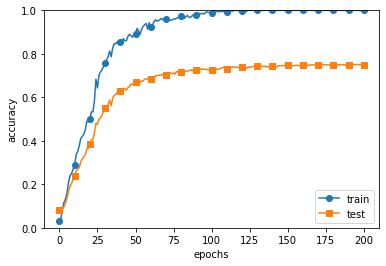

In [37]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

weight_decay_lambda = 0


network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

訓練データとテストデータでの隔たりが確認できる。

# Weight decay

過学習抑制のために昔からよく用いられている手法に、Weight decay(荷重減衰)と呼ばれるものがある。これは、学習の過程において、大きな重みをもつことにペナルティを課すことで、過学習を抑制しようというものだ。重みの2乗ノルムを加算することで重みが大きくなることを抑制している。

epoch:0, train acc:0.20333333333333334, test acc:0.1666
epoch:1, train acc:0.22, test acc:0.182
epoch:2, train acc:0.24333333333333335, test acc:0.1944
epoch:3, train acc:0.26, test acc:0.2134
epoch:4, train acc:0.29, test acc:0.2242
epoch:5, train acc:0.29333333333333333, test acc:0.237
epoch:6, train acc:0.3233333333333333, test acc:0.2486
epoch:7, train acc:0.3433333333333333, test acc:0.2602
epoch:8, train acc:0.36, test acc:0.2739
epoch:9, train acc:0.35333333333333333, test acc:0.2851
epoch:10, train acc:0.36666666666666664, test acc:0.2958
epoch:11, train acc:0.37666666666666665, test acc:0.3047
epoch:12, train acc:0.41, test acc:0.3195
epoch:13, train acc:0.44333333333333336, test acc:0.3367
epoch:14, train acc:0.44666666666666666, test acc:0.3361
epoch:15, train acc:0.45666666666666667, test acc:0.3411
epoch:16, train acc:0.5066666666666667, test acc:0.3642
epoch:17, train acc:0.5433333333333333, test acc:0.3916
epoch:18, train acc:0.5633333333333334, test acc:0.4054
epoch:19,

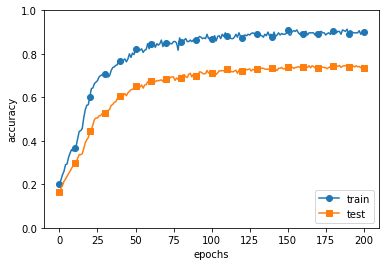

In [36]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# Dropout

過学習を抑制する方法としてWeightdecayを説明した。これは実装が簡単な反面、ニューラルネットワークのモデルが複雑になるとWeightdecayだけでの対応が困難になってくる。そこでDropoutという手法を用いる。
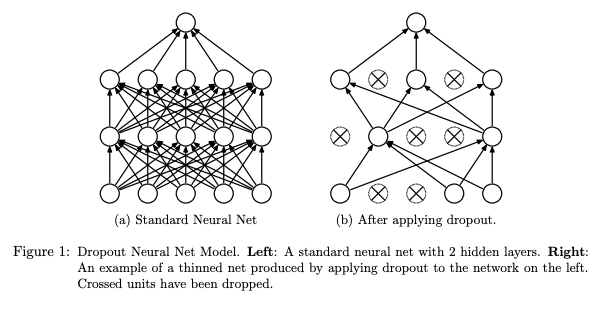

Dropoutはニューロンをランダムに消去しながら学習する手法で訓練時にはデータが流れるたびに、消去するニューロンをランダムに選び、テスト時にはすべてのニューロン信号を伝達し、その出力に対して、訓練時に消去した割合を乗算して出力する。

train loss:2.297588074146941
=== epoch:1, train acc:0.11, test acc:0.1123 ===
train loss:2.315453537798621
train loss:2.3125016150741162
train loss:2.2889642654539766
=== epoch:2, train acc:0.10666666666666667, test acc:0.1145 ===
train loss:2.299252045734113
train loss:2.3099053082972723
train loss:2.292899460329589
=== epoch:3, train acc:0.10666666666666667, test acc:0.1152 ===
train loss:2.293970817282937
train loss:2.3028095282465
train loss:2.2961331611578073
=== epoch:4, train acc:0.10666666666666667, test acc:0.1171 ===
train loss:2.2963754497356974
train loss:2.2980568569154145
train loss:2.2904504442624187
=== epoch:5, train acc:0.12, test acc:0.1175 ===
train loss:2.308676492544634
train loss:2.3044941313358804
train loss:2.287115262045506
=== epoch:6, train acc:0.12333333333333334, test acc:0.1206 ===
train loss:2.30252476472437
train loss:2.2960409123277614
train loss:2.3004154922257767
=== epoch:7, train acc:0.12666666666666668, test acc:0.1251 ===
train loss:2.29606296680

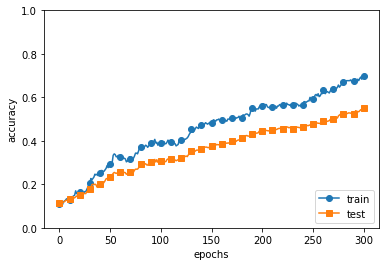

In [38]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

認識精度が100％になることもなく、隔たりも小さくなった。

# ハイパーパラメータの検証

ハイパーパラメータとは、重みやバイアスとは別で、各層のニューロンやバッチサイズ、パラメータ更新の際の学習係数や、WeightDecayのことをさす。

# 検証データ

テストデータを用いてハイパーパラメータの性能を評価してはならない。理由は、テストデータに対して過学習を起こし、ほかのデータに対しては適応できない汎化性能の低いモデルになる可能性があるためだ。ハイパーパラメータの専用の調整データは、一般的に検証データと呼ばれる。

# ハイパーパラメータの最適化

#### ステップ０
　　ハイパーパラメータの範囲をざっくりと設定する
  
#### ステップ1
　　設定されたハイパーパラメータの範囲から、ランダムにサンプリングする。

#### ステップ2
　　ステップ1でサンプリングされたハイパーパラメータの値を利用して学習を行い、検証データで認識精度を評価する。(ただしエポックは小さく設定）

#### ステップ3
　　ステップ1とステップ2をある回数（100回など）繰り返し、それらの認識精度の結果から、ハイパーパラメータな範囲を狭める。

上記を繰り返し、範囲を絞り込み、その絞り込んだ範囲からハイパーパラメータの値を一つ選び出す。

# ハイパーパラメータ最適化の実装

ハイパーパラメータのけんしょうは、0.001(10^-3)から1000(10^3)のような対数スケールの範囲からランダムでサンプリングして検証していく。これは、Pythonでは10 ** np.rando,.uniform(-3,-4)と書くことができる。

val acc:0.09 | lr:9.216452745310426e-05, weight decay:1.6799578231246626e-05
val acc:0.54 | lr:0.004182572944508971, weight decay:6.568594576698725e-05
val acc:0.25 | lr:0.001220499353068639, weight decay:5.676176873579045e-07
val acc:0.08 | lr:3.055540840169755e-05, weight decay:3.761039769490305e-07
val acc:0.37 | lr:0.0011916877521478445, weight decay:5.1799266570060984e-05
val acc:0.1 | lr:6.407579700494172e-05, weight decay:5.3680708716144596e-05
val acc:0.19 | lr:0.0008093846502907576, weight decay:1.8725881872563937e-08
val acc:0.13 | lr:0.0010616939684177744, weight decay:7.632704830721958e-07
val acc:0.31 | lr:0.002571006244337465, weight decay:5.894608819173608e-07
val acc:0.09 | lr:1.0317061694727382e-06, weight decay:1.806537833546366e-08
val acc:0.58 | lr:0.0040873794069676995, weight decay:5.574254896732363e-07
val acc:0.08 | lr:5.406671560639227e-05, weight decay:3.1453403818177625e-06
val acc:0.08 | lr:0.00020928185490917694, weight decay:7.436662250713189e-07
val acc:0

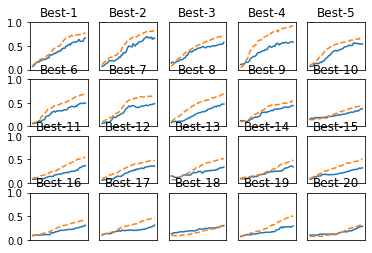

In [39]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()